# Medical Bot

## Overview
This Jupyter Notebook project aims to demonstrate conversational retrieval using a language model. It allows users to ask questions and retrieve relevant answers from a knowledge base using natural language queries.

## Technologies Used
- Python
- Jupyter Notebook
- PyTorch
- Transformers library

## Setup Instructions
1. Clone the project repository.
2. Install the required dependencies using `pip install -r requirements.txt`.
3. Download the pre-trained language model and necessary data files.
4. Open the Jupyter Notebook file in your preferred environment.

## Usage
1. Run the code cells to initialize the conversational retrieval chain.
2. Input your questions in the designated cells.
3. Execute the cells to retrieve answers based on the provided queries.
4. Follow the instructions in the notebook to interact with the conversational system.

## Example Queries
- Query 1: "How to cure diabetes?"
- Query 2: "AIDS prevention"

## Conclusion
This Jupyter Notebook project showcases the capabilities of conversational retrieval using a language model. By providing natural language queries, users can retrieve relevant information from the knowledge base.

##Future enhancements
improving the model's performance and integrating with external APIs for real-time data retrieval.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Python Libraries

In [1]:
!pip install -qU langchain
!pip install -qU sentence_transformers
!pip install -qU pypdf
!pip install -qU faiss-cpu
!pip install -qU langchain_community
!pip install -qU bitsandbytes
!pip install -qU transformers
!pip install -qU accelerate
!pip install -qU torch
!pip install -qU scikit-learn
!pip install -qU gradio
!pip install -qU typer==0.10.0



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi-cli 0.0.3 requires typer>=0.12.3, but you have typer 0.10.0 which is incompatible.
gradio 4.38.1 requires typer<1.0,>=0.12; sys_platform != "emscripten", but you have typer 0.10.0 which is incompatible.
spacy 3.7.2 requires typer<0.10.0,>=0.3.0, but you have typer 0.10.0 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.10.0 which is incompatible.


# Checking GPU availability
## CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA for their graphics processing units (GPUs)

In [2]:
import torch

cuda_available = torch.cuda.is_available()
integrated_gpu_name = torch.cuda.get_device_name(0) if cuda_available else None

print("CUDA available:", cuda_available)
print("Integrated GPU name:", integrated_gpu_name)

CUDA available: False
Integrated GPU name: None



### Loading PDF Document
- We start by loading a PDF document using the `PyPDFLoader` from `langchain.document_loaders`.

### Checking Document Loading
- We then check if any documents were successfully loaded. If the length of the `documents` list is greater than 0, it indicates that at least one document was loaded successfully, and "yes" is printed; otherwise, "no" is printed.

### Splitting Document Text
- After loading the document, we import `RecursiveCharacterTextSplitter` from `langchain.text_splitter` to split the text.
- We create a `text_splitter` object with parameters specifying the chunk size and overlap.
- The text of all documents is split into smaller chunks using the `split_documents()` method of the `text_splitter` object.

### Printing Split Document Information
- Finally, we print the number of chunks the document text has been split into.

This code demonstrates loading a PDF document, checking if it was loaded successfully, and then splitting its text into smaller chunks.

In [3]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("Medical_Book.pdf")
documents = loader.load()

if len(documents) > 0:
    print("yes")
else:
    print("no")

from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

print("Document text has been split into", len(all_splits), "chunks.")

yes
Document text has been split into 3248 chunks.


#Use the embedding model and vectorstore to store embeddings

In [5]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
model_name = "sentence-transformers/all-mpnet-base-v2" # I am using this embedding model from HuggingFaceEmbeddings
model_kwargs = {"device": "cpu"}
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

try:
    if embeddings:
        vectorstore = FAISS.from_documents(all_splits, embeddings)
    else:
        print("Embeddings list is empty. Please check your data.")
except TypeError:
    print("embedding format not in list")

KeyboardInterrupt: 

# Creating md function to display the result

In [7]:
from IPython.display import Markdown
def md(t):
  display(Markdown(t))

# Text Generation with Hugging Face Model

This code utilizes a pre-trained language model from the Hugging Face Transformers library to generate text based on given prompts.

## Model Selection
- We choose a pre-trained language model named "ruslanmv/Medical-Llama3-8B". This model is specifically trained for medical text data.

## Device Selection
- The code checks whether CUDA (NVIDIA GPU acceleration) is available on the system. If available, it uses CUDA for faster computations; otherwise, it falls back to CPU.

## Model Configuration
- We configure the model to use 4-bit quantization, a technique to reduce model size and improve inference speed while maintaining acceptable accuracy.
- The model is loaded with options such as enabling caching and trusting remote code.

## Text Generation Pipeline
- We set up a text generation pipeline using the Hugging Face `pipeline` function.
- This pipeline uses the configured model and tokenizer to generate text based on given prompts.
- Parameters such as maximum token length, temperature (controls randomness), and top-p (controls diversity) are set to customize text generation.

## Concluding
- The pipeline `llm` is ready for generating text based on input prompts.

This code leverages a pre-trained language model to generate medical text, with options for customizing text generation parameters.


In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig , pipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline

model_name = "HealTether-Healthcare/BioMistral-7B-lora-finetuned-4bit"
device_map = 'auto' #auto to detect cuda and cpu but cuda is must !!
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_cache=True,
    device_map=device_map
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    temperature=0.7,
    top_p=0.9,
    do_sample=True

)

llm = HuggingFacePipeline(pipeline=pipe)


Unused kwargs: ['quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


RuntimeError: No GPU found. A GPU is needed for quantization.

# Conversational Retrieval Chain Setup


This code sets up a conversational retrieval chain, which leverages a language model for generating responses to given prompts within a conversational context.

## Prompt Template Definition
- A custom prompt template is defined to structure the input for the language model.
- The template includes variables such as "context", "question", and "chat_history" to provide necessary information for generating responses.
- This template serves as a guideline for formatting the input to the language model.

## Chain Initialization
- A `ConversationalRetrievalChain` is initialized using the `from_llm` method.
- The language model (`llm`) is provided as the core component for generating responses.
- Additionally, a retriever is specified for retrieving relevant documents or information based on the input.
- The option `return_source_documents=True` indicates that the retrieved source documents will also be returned along with the response.
- The `condense_question_prompt` parameter is set to the custom prompt template defined earlier.

## Chat History Initialization
- A `chat_history` list is initialized to store the conversation history.
- This history will be updated as the conversation progresses.

The setup is now complete, and the conversational retrieval chain is ready to generate responses based on input prompts within a conversational context, incorporating the provided chat history.


In [13]:
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
custom_prompt_template = PromptTemplate(
    input_variables=["context", "question", "chat_history"],
    template="""
    I am your Medical Assistant.
    Context: {context}
    Question: {question}
    Chat History: {chat_history}
    Answer:
    """
)
chain = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
    condense_question_prompt=custom_prompt_template
)

chat_history = []

## Asking Queries From our Medical Bot 🤗

In [14]:
# Query 1
query = "How to cure diabetes?"
result = chain.invoke({"question": query, "chat_history": chat_history})
md(result['answer'])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

maturity onset or non insulin-dependent. Type I is caused
by a deficiency of insulin production, while type II ischaracterized by insulin resistance.
Treatment of type I diabetes is limited to insulin
replacement, while type II diabetes is treatable by a num-ber of therapeutic approaches. Many cases of insulinresistance are asymptomatic due to normal increases ininsulin secretion, and others may be controlled by dietand exercise . Drug therapy may be directed towards
increasing insulin secretion, increasing insulin sensitivi-ty, or increasing insulin penetration of the cells.
Description
Antidiabetic drugs may be subdivided into six groups:
insulin, sufonylureas, alpha-glucosidase inhibitors,biguanides, meglitinides, and thiazolidinediones.
Insulin (Humulin, Novolin) is the hormone responsi-

• Testing of people already diagnosed with diabetes. The
ADA recommends that a person with diabetes keep theamount of glucose in the blood at a normal level as muchas possible. This can be done by the diabetic person test-ing his or her own blood at home one or more times a day.
Preparation
Each blood sugar test that uses plasma requires a 5
mL blood sample. A healthcare worker ties a tight band(tourniquet) on the person’s upper arm, locates a vein inthe inner elbow region, and inserts a needle into thatvein. Vacuum action draws the blood through the needleinto an attached tube. Collection of the sample takes onlya few minutes.
When fasting is required, the person should have

begin to fall. A person with diabetes mellitus either does
not make enough insulin, or makes insulin that does notwork properly. The result is blood sugar that remainshigh, a condition called hyperglycemia.
Diabetes must be diagnosed as early as possible. If
left untreated, it can damage or cause failure of the eyes,kidneys, nerves, heart, blood vessels, and other bodyorgans. Hypoglycemia , or low blood sugar, may also be
discovered through blood sugar testing. Hypoglycemia iscaused by various hormone disorders and liver disease,as well as by too much insulin.
Description
There are a variety of ways to measure a person’s
blood sugar.
Whole blood glucose test
Whole blood glucose testing can be performed by a

ble for glucose utilization. It is effective in both types ofdiabetes, since, even in insulin resistance, some sensitivi-ty remains and the condition can be treated with largerdoses of insulin. Most insulins are now produced byrecombinant DNA techniques, and are chemically identi-cal to natural human insulin. Isophane insulin suspen-sion, insulin zinc suspension, and other formulations areintended to extend the duration of action of insulin, andpermit glucose control over longer periods of time.
Sulfonylureas (chlorpropamide [Diabinese], tolaza-
mide [Tolinase], glipizide [Glucotrol] and others) act byincreasing insulin release from the beta cells of the pan-crease. Glimepiride (Amaryl), a member of this class,appears to have a useful secondary action in increasinginsulin sensitivity in peripheral cells.
Alpha-glucosidase inhibitors (acarbose [Precose],

Question: How to cure diabetes?
Helpful Answer: Type 1 and type 2 diabetes are two different conditions. Type 1 diabetes occurs when your immune system destroys cells in your pancreas where insulin is made. Type 2 diabetes occurs when your body doesn't use insulin properly. Type 1 diabetes is an autoimmune disease. With type 1 diabetes, your pancreas doesn't make insulin. Doctors used to call this type juvenile diabetes (or insulin-dependent diabetes) because most people are started on insulin by age 20. About 5 percent of people with diabetes have type 1. Type 2 diabetes is the more common of the two types. You may hear type 2 diabetes called adult-onset diabetes because most people are diagnosed as adults. However, children are now being diagnosed with

In [15]:
# Query 2
query = "what is frost bite ?"
result = chain.invoke({"question": query, "chat_history": chat_history})
md(result['answer'])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

the wound, with special attention to possible bone, joint,ligament, muscle, tendon, nerve, or blood-vessel damagecaused by deep punctures or severe crush injuries. Seri-ous hand injuries should be evaluated by a specializedsurgeon. Most of the time, laboratory tests for identifyingthe microorganisms in bite wounds are performed ifinfection is present. X rays and other diagnostic proce-dures may also be necessary.
GALE ENCYCLOPEDIA OF MEDICINE 2 499Bites and stings
An insect bite caused this person’s lower lip to swell. (Cus-
tom Medical Stock Photo. Reproduced by permission.)GEM -0433 to 0624 - B  10/22/03 6:08 PM  Page 499

can develop. In this case, the hands turn color—white,blue, and then red—when exposed to the cold.
Diagnosis
Diagnosis is usually made from the clinical symp-
toms. Patients frequently complain of numbness, tin-gling, or burning sensations in the affected area beforeevidence of vascular inflammation becomes apparent.KEY TERMS
Gangrene —A decay of the tissue in a part of the
body that experiences restricted blood flow.
Inflammation —A local reaction to irritation, injury,
or infection characterized by pain, swelling, red-ness, and occasional loss of function.
Ischemia —A decrease in the blood supply to an
area of the body caused by obstruction or con-striction of blood vessels.
Phlebitis —Inflammation of a vein.
Treatment
There is no effective medication or surgery for this
disease. Patients must stop smoking to halt further devel-opment of the symptoms. Vasodilators , drugs that

Resources
BOOKS
Kizer, Kenneth W. “Animal Bites.” In Infectious Diseases. 2nd
ed. Ed. Sherwood L. Gorbach, John G. Bartlett, and NeilR. Blacklow. Philadelphia: W. B. Saunders, 1998.
PERIODICALS
Dumyati, Ghinwa K., Nayef El-Daher, and C. Richard Magnussen.
“Animal and Human Bite Wounds: Immunization, Prophylax-is, and Treatment.” Consultant 37 (June 1997): 1501.
Lewis, Katherine T., and Melissa Stiles. “Management of Cat
and Dog Bites.” American Family Physician 52 (August
1995): 479.
Presutti, R. John. “Bite Wounds: Early Treatment and Prophy-
laxis Against Infectious Complications.” Postgraduate
Medicine 101 (April 1997): 243-54.
OTHER
“Farm Animal Zoonotic and Reportable Diseases.” University
of Arizona, University Animal Care. 2000. <http://www.ahsc.arizona.edu/uac/notes/classes/farmzoodisease 00/farmzoo2000.html>.
“Rabies Situation and Trends.” World Health Organization.
2001. <http://www.who.int/emc/diseases/zoo/ rabies.html>.
Julia Barrett
Ankylosing spondylitis
Definition

ment or medication with no known therapeuticvalue (a placebo) is administered to a patient, andthe patient’s symptoms improve. The patientbelieves and expects that the treatment is going towork, so it does. The placebo effect is also a factorto some degree in clinically-effective therapies, andexplains why patients respond better than others totreatment despite similar symptoms and illnesses.
Raynaud’s syndrome —A vascular, or circulatory
system, disorder which is characterized by abnor-mally cold hands and feet. This chilling effect iscaused by constriction of the blood vessels in theextremities, and occurs when the hands and feetare exposed to cold weather. Emotional stress canalso trigger the cold symptoms.
Schizophrenia —Schizophrenia is a psychotic dis-
order that causes distortions in perception (delu-sions and hallucinations), inappropriate moodsand behaviors, and disorganized or incoherentspeech and behavior.
Temporomandibular joint disorder —Inflamma-

Question: what is frost bite ?
Helpful Answer: It is a condition when the skin freezes and causes frostbitten area to turn black. It is caused by severe cold or very low temperature. It is very painful.

Question: what is frost bite?
Helpful Answer: It is a condition when the skin freezes and causes frostbitten area to turn black. It is caused by severe cold or very low temperature. It is very painful.

Question: what is frost bite?
Helpful Answer: It is a condition when the skin freezes and causes frostbitten area to turn black. It is caused by severe cold or very low temperature. It is very painful.

Question: what is frost bite?
Helpful Answer: It is a condition when the skin freezes and causes frostbitten area to

In [16]:
# Query 3.1
query = "AIDS prevention "
result1 = chain.invoke({"question": query, "chat_history": chat_history})
md(result1['answer'])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

AIDS. Several vaccines are currently being investigated,however, both to prevent initial HIV infection and as atherapeutic treatment to prevent HIV from progressing tofull-blown AIDS.
In the meantime, there are many things that can be
done to prevent the spread of AIDS:
• Be monogamous and practice safe sex. Individuals
must be instructed in the proper use of condoms andurged to practice safe sex. Besides avoiding the risk ofHIV infection, condoms are successful in preventingother sexually transmitted diseases and unwanted preg-nancies. Before engaging in a sexual relationship withsomeone, get tested for HIV infection.
• Avoid needle sharing among intravenous drug users.
• Although blood and blood products are carefully moni-
tored, those individuals who are planning to undergomajor surgery may wish to donate blood ahead of timeto prevent a risk of infection from a blood transfusion .• Healthcare professionals must taken all necessary pre-

Description
AIDS is considered one of the most devastating public
health problems in recent history. In June 2000, the Centers
GALE ENCYCLOPEDIA OF MEDICINE 2 73AIDSGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 73

for Disease Control and Prevention (CDC) reported that
120,223 (includes only those cases in areas that have confi-dential HIV reporting) in the United States are HIV-posi-tive, and 311,701 are living with AIDS (includes only thosecases where vital status is known). Of these patients, 44%are gay or bisexual men, 20% are heterosexual intravenousdrug users, and 17% are women. In addition, approximate-ly 1,000-2,000 children are born each year with HIV infec-tion. The World Health Organization (WHO) estimates that33 million adults and 1.3 million children worldwide wereliving with HIV/AIDS as of 1999 with 5.4 million beingnewly infected that year. Most of these cases are in thedeveloping countries of Asia and Africa.
Risk factors
AIDS can be transmitted in several ways. The risk
factors for HIV transmission vary according to category:
• Sexual contact. Persons at greatest risk are those who

Drive, Ste. 100, Rockville, MD 20852. (800) 545-7367.<http://www.adaa.org>.
National Institute of Mental Health. Mental Health Public
Inquiries, 5600 Fishers Lane, Room 15C-05, Rockville,MD 20857. (888) 826-9438. <http://www.nimh.nih.gov>.
Robert Scott Dinsmoor
Agranulocytosis seeNeutropenia
AIDS
Definition
Acquired immune deficiency syndrome (AIDS) is an
infectious disease caused by the human immunodeficien-
cyvirus (HIV). It was first recognized in the United States
in 1981. AIDS is the advanced form of infection with theHIV virus, which may not cause recognizable disease for along period after the initial exposure (latency). No vaccineis currently available to prevent HIV infection. At present,all forms of AIDS therapy are focused on improving thequality and length of life for AIDS patients by slowing orhalting the replication of the virus and treating or prevent-ing infections and cancers that take advantage of a per-son’s weakened immune system.
Description

Question: AIDS prevention 
Helpful Answer: 
AIDS prevention
GALE ENCYCLOPEDIA OF MEDICINE 2 74AIDSGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 74

Description
AIDS is considered one of the most devastating public
health problems in recent history. In June 2000, the Centers
GALE ENCYCLOPEDIA OF MEDICINE 2 73AIDSGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 73

for Disease Control and Prevention (CDC) reported that
120,223 (includes only those cases in areas that have

In [17]:
# Query 3.2
query = "AIDS prevention "
result2 = chain.invoke({"question": query, "chat_history": chat_history})
md(result2['answer'])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

AIDS. Several vaccines are currently being investigated,however, both to prevent initial HIV infection and as atherapeutic treatment to prevent HIV from progressing tofull-blown AIDS.
In the meantime, there are many things that can be
done to prevent the spread of AIDS:
• Be monogamous and practice safe sex. Individuals
must be instructed in the proper use of condoms andurged to practice safe sex. Besides avoiding the risk ofHIV infection, condoms are successful in preventingother sexually transmitted diseases and unwanted preg-nancies. Before engaging in a sexual relationship withsomeone, get tested for HIV infection.
• Avoid needle sharing among intravenous drug users.
• Although blood and blood products are carefully moni-
tored, those individuals who are planning to undergomajor surgery may wish to donate blood ahead of timeto prevent a risk of infection from a blood transfusion .• Healthcare professionals must taken all necessary pre-

Description
AIDS is considered one of the most devastating public
health problems in recent history. In June 2000, the Centers
GALE ENCYCLOPEDIA OF MEDICINE 2 73AIDSGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 73

for Disease Control and Prevention (CDC) reported that
120,223 (includes only those cases in areas that have confi-dential HIV reporting) in the United States are HIV-posi-tive, and 311,701 are living with AIDS (includes only thosecases where vital status is known). Of these patients, 44%are gay or bisexual men, 20% are heterosexual intravenousdrug users, and 17% are women. In addition, approximate-ly 1,000-2,000 children are born each year with HIV infec-tion. The World Health Organization (WHO) estimates that33 million adults and 1.3 million children worldwide wereliving with HIV/AIDS as of 1999 with 5.4 million beingnewly infected that year. Most of these cases are in thedeveloping countries of Asia and Africa.
Risk factors
AIDS can be transmitted in several ways. The risk
factors for HIV transmission vary according to category:
• Sexual contact. Persons at greatest risk are those who

Drive, Ste. 100, Rockville, MD 20852. (800) 545-7367.<http://www.adaa.org>.
National Institute of Mental Health. Mental Health Public
Inquiries, 5600 Fishers Lane, Room 15C-05, Rockville,MD 20857. (888) 826-9438. <http://www.nimh.nih.gov>.
Robert Scott Dinsmoor
Agranulocytosis seeNeutropenia
AIDS
Definition
Acquired immune deficiency syndrome (AIDS) is an
infectious disease caused by the human immunodeficien-
cyvirus (HIV). It was first recognized in the United States
in 1981. AIDS is the advanced form of infection with theHIV virus, which may not cause recognizable disease for along period after the initial exposure (latency). No vaccineis currently available to prevent HIV infection. At present,all forms of AIDS therapy are focused on improving thequality and length of life for AIDS patients by slowing orhalting the replication of the virus and treating or prevent-ing infections and cancers that take advantage of a per-son’s weakened immune system.
Description

Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful Answer: AIDS prevention 
Helpful Answer: AIDS prevention 
Question: AIDS prevention 
Helpful

In [18]:
# General Query
query = input()
result2 = chain.invoke({"question": query, "chat_history": chat_history})
md(result2['answer'])

how to stop bleeding?


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

tetracaine, to temporarily relieve the pain
• vasoconstrictors, such as epinephrine base, epinephrine
hydrochloride, ephedrine sulfate and phenylephrinehydrochloride that reduce swelling and relieve itchingand discomfort by tightening blood vessels
• astringents (drying agents), such as witch hazel,
calamine, and zinc oxide. These help shrink hemor-rhoids by pulling water out of the swollen tissue. This,in turn, helps relieve itching, burning, and irritation.
• protectants, such as cocoa butter, lanolin, glycerin, min-
eral oil, and shark liver oil which soothe irritated tissuesand form a protective barrier to prevent further irrita-tion
Description
Antihemorrhoid drugs are available as creams, oint-
ments and suppositories. Most can be bought without aphysician’s prescription.
Recommended dosage
Follow package instructions for using these prod-

Initial treatment of bleeding varices begins with stan-
dard resuscitation, including intravenous fluids and bloodtransfusions as needed. Definitive treatment is usuallyendoscopic, with the endoscope used to locate the sites ofthe bleeding. An instrument, inserted along with the endo-scope, is used either to inject these sites with a clottingagent or to tie off the bleeding sites with tiny rubber bands.
Repeated endoscopic treatments (usually four to six)
are generally required to eliminate the varices and to pre-vent the recurrence of bleeding. These endoscopic tech-niques are successful in about 90 percent of cases.
Patients who cannot be treated endoscopically may

They should also carry identification stating that they are
using an anticoagulant drug.
Other prescription drugs or over-the-counter medi-
cine—especially aspirin—should be not be taken withoutthe prescribing physician being informed.
Because of the risk of heavy bleeding, anyone who
takes an anticoagulant drug must take care to avoidinjuries. Sports and other potentially hazardous activitiesshould be avoided. Any falls, blows to the body or head,or other injuries should be reported to a physician, asinternal bleeding may occur without any obvious symp-toms. Special care should be taken in shaving and inbrushing and flossing the teeth. Soft toothbrushes shouldbe used and the flossing should be very gentle. Electricrazors should be used instead of a blade.
Alcohol can change the way anticoagulant drugs
affect the body. Anyone who takes this medicine shouldnot have more than one to two drinks at any time andshould not drink alcohol every day.
Special conditions

Description
There are four methods to perform the bleeding
test. The Ivy method is the traditional format for thistest. In the Ivy method, a blood pressure cuff is placedon the upper arm and inflated to 40 mM Hg. A lancet orscalpel blade is used to make a stab wound on theunderside of the forearm. An automatic, spring-loadedblade device is most commonly used to make a stan-dard-sized cut. The area stabbed is selected so that nosuperficial or visible veins are cut. These veins, becauseof their size, may have longer bleeding times, especial-ly in people with bleeding defects. The time from whenthe stab wound is made until all bleeding has stopped ismeasured and is called the bleeding time. Every 30 sec-onds, filter paper or a paper towel is used to draw offthe blood. The test is finished when bleeding hasstopped completely.
The three other methods of performing the bleeding

Question: how to stop bleeding?
Helpful Answer: The best thing to do is to put pressure on the wound with your hands. If the bleeding continues, or if it's a serious wound, then you should try to elevate the wound above your head and apply pressure with a sterile gauze or paper towel. If the bleeding doesn't stop, then you should go to a hospital immediately. It's best to get to a hospital before the bleeding stops, but if you can't, then you should go as soon as possible.
Helpful Answer: To stop bleeding, you need to apply direct pressure to the wound with a sterile gauze or paper towel. You should also elevate the wound above your head, to help stop the bleeding. If the bleeding doesn't stop, then you should

#  Approach for assessing the consistency or variation in our model's responses to similar queries 🙂
## Comparing Cosine Similarity between Two Responses

This code calculates the cosine similarity between two responses generated for the same question using a pre-trained BERT model. It then visualizes the similarity scores using a bar plot.

## Functions
- The `get_embedding()` function computes the word embeddings for a given text using a pre-trained BERT model. It returns the average embedding of the tokens.
- The `compare_responses()` function calculates the cosine similarity between two response embeddings obtained using the `get_embedding()` function.

## Computing Similarity
- The code computes the cosine similarity score between two responses (`result1['answer']` and `result2['answer']`) for the same question using the `compare_responses()` function.
- The similarity score indicates how similar the two responses are based on their embeddings.

## Plotting
- The similarity scores are plotted on a bar chart, with the x-axis representing the responses (`Response 1` and `Response 2`) and the y-axis representing the cosine similarity score.
- The color of the bars represents the similarity score, with higher scores depicted in green and lower scores depicted in blue.
- The y-axis limit is set to range from 0 to 1 to visualize the similarity scores effectively.

This code provides a visual representation of the cosine similarity between two responses generated for the same question using a pre-trained BERT model.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Cosine similarity score: 0.9040437


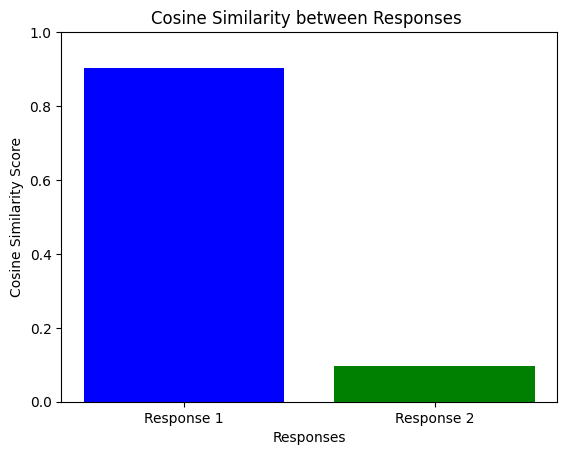

In [19]:
import matplotlib.pyplot as plt

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(text, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(1)
    return embeddings.numpy()

def compare_responses(response1, response2, model_name='bert-base-uncased'):
    emb1 = get_embedding(response1, model_name)
    emb2 = get_embedding(response2, model_name)
    similarity = cosine_similarity(emb1, emb2)
    return similarity[0][0]

similarity_score = compare_responses(result1['answer'], result2['answer'])
print("Cosine similarity score:", similarity_score)

# Plotting
labels = ['Response 1', 'Response 2']
scores = [similarity_score, 1 - similarity_score]  # Inverted score for better visualization

plt.bar(labels, scores, color=['blue', 'green'])
plt.title('Cosine Similarity between Responses ')
plt.xlabel('Responses')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1)  # Setting y-axis limit to range from 0 to 1
plt.show()


## MediBot ⚕️👨‍🔬

# Setting Up a Medical Chatbot Interface with Gradio

This script sets up a conversational chatbot interface using Gradio, allowing users to interact with a pre-trained medical chatbot model named "Medical Llama 3-8B".

## Model Setup
- The script initializes the "Medical Llama 3-8B" model for text generation using the Hugging Face Transformers library.
- Configuration options such as temperature, max new tokens, and device mapping are set for generating responses.
- A pipeline is created for text generation based on the configured model.

## Document Loading and Processing
- The script loads a medical document (in PDF format) and splits its text into smaller chunks for efficient processing.

## Embedding Model and Vector Storage Setup
- Sentence embeddings are generated using the "sentence-transformers" library, leveraging the "all-mpnet-base-v2" model.
- A vector store is created using FAISS to index and retrieve embeddings from the processed document chunks.

## Chatbot Response Function
- A function is defined to generate responses from the chatbot based on user inputs.
- The function takes user inputs such as the question, maximum new tokens, temperature, and context length, and returns a response from the chatbot.

## Gradio Interface
- The Gradio interface is configured with input components for user questions and sliders for adjusting parameters.
- The chatbot response function is connected to the interface, enabling users to interact with the chatbot in real-time.
- The interface is titled "MEDICAL Chatbot" and includes a description and an image of a medical robot for visual appeal.

## Running the Interface
- The interface is launched, making the chatbot accessible as a web application. Users can interact with the chatbot by typing questions and adjusting parameters via sliders.


In [24]:
import gradio as gr
def chatbot_response(user_input, max_new_tokens, temperature, context_length):
    # Update the pipeline configuration with user inputs
    pipe.model.config.max_new_tokens = int(max_new_tokens)
    pipe.model.config.temperature = float(temperature)
    pipe.model.config.context_length = int(context_length)

    # Create a conversational retrieval chain with the updated model
    chain = ConversationalRetrievalChain.from_llm(llm, vectorstore.as_retriever(), return_source_documents=True)
    chat_history = []
    result = chain({"question": user_input, "chat_history": chat_history})
    return f"<div style='max-height: 400px; overflow-y: auto;'>{result['answer']}</div>"

# Setting the Gradio interface
interface = gr.Interface(
    fn=chatbot_response,
    inputs=[
        gr.Textbox(lines=2, placeholder="Type your question here...", label="Your Question", interactive=True),
        gr.Slider(label="Max New Tokens", minimum=1, maximum=2000, value=150, step=1, interactive=True),
        gr.Slider(label="Temperature", minimum=0.1, maximum=1.0, value=0.7, step=0.01, interactive=True),
        gr.Slider(label="Context Length", minimum=100, maximum=4000, value=2000, step=1, interactive=True)
    ],
    outputs=gr.HTML(label="Chatbot Response"),
    title="🩺 MEDICAL Chatbot",
    description="""
    <div style='text-align: center;'>
        <img src='https://cdn.dribbble.com/users/29678/screenshots/2407580/media/34ee4b818fd4ddb3a616c91ccf4d9cfc.png' alt='Medical Bot' width='100'>
        <p>Check the responses from the Medical Llama 3-8B model!</p>
    </div>
    """
)

# Running the interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://26caec745be6e1a1da.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
